In [2]:
import sys
sys.path.append('../')  # make modules in repo root available

In [3]:
import random
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import torch

from utils.datasets.niab import SegmentationDataset, IMG_TRANSFORMS, MASK_TRANSFORMS

In [4]:
niab_dataset = SegmentationDataset(
    "../datasets/niab/EXP01/Top_Images/Masked_Dataset/imgs", 
    "../datasets/niab/EXP01/Top_Images/Masked_Dataset/masks",
    img_transform=IMG_TRANSFORMS, mask_transform=MASK_TRANSFORMS
)

Running model using cuda device
Unique values in prediction: tensor([0., 1.], device='cuda:0')


(-0.5, 255.5, 255.5, -0.5)

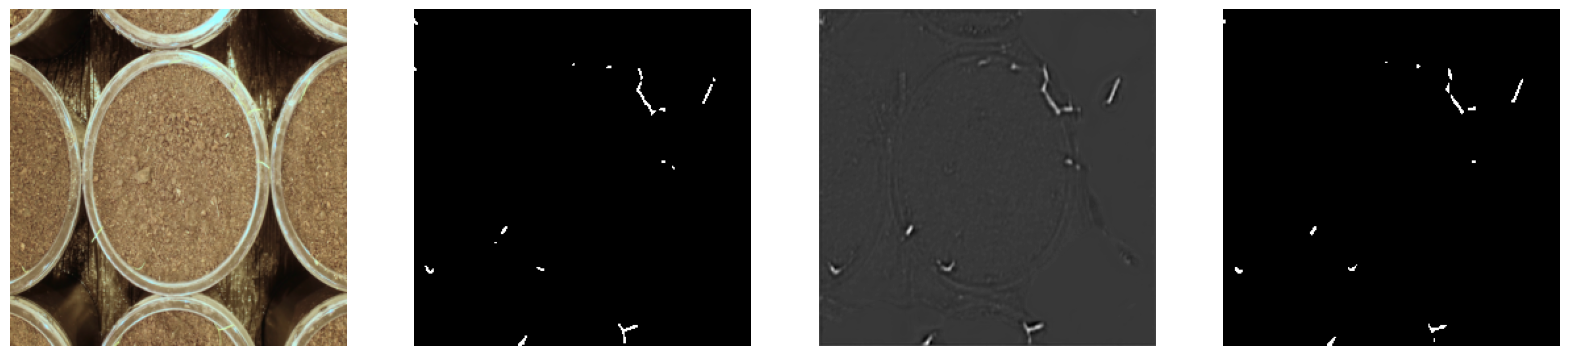

In [9]:
MODEL_PATH = "../models/best_model.pth"

device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Running model using {device} device")

random_index = random.randint(0, len(niab_dataset) - 1)  # Take an image at random from the training dataset

# Take a random image from the test dataset
# raw_img, raw_mask = data_raw[random_index]
processed_img, processed_mask = niab_dataset[random_index]

# Create an instance of the model and move it to the device (GPU or CPU) and load the model parameters
model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
).to(device)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()  # Set model to evaluation mode i.e. doesn't change weights

# Make a prediction
pred = model(processed_img.unsqueeze(0).to(device))

threshold = 0.7
pred_binary = (pred > threshold).float()

# check pred_binary is binary
print(f"Unique values in prediction: {torch.unique(pred_binary)}")

# Plot the image, mask and prediction next to each other
plt.figure(figsize=(20, 10))  # Adjust the width (15) and height (5) as needed

plt.subplot(1, 4, 1)
plt.imshow(processed_img.cpu().detach().permute(1, 2, 0))
plt.axis('off')
plt.subplot(1, 4, 2)
plt.imshow(processed_mask.cpu().detach().permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow(pred[0].cpu().detach().permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.subplot(1, 4, 4)
plt.imshow(pred_binary[0].cpu().detach().permute(1, 2, 0), cmap='gray')  # quantized after based on prediction estimates
plt.axis('off')

In [ ]:
# Plant canopy coverage (PCC) ratio

# IDEA: Make sure segments are consistent and remove shapes that do not begin within the approximate area of pot (e.g. expect that shapes that have a starting point outside of the pot are not part of the plants being measured)